In [9]:
%matplotlib inline

In [12]:
import json
from pathlib import Path
import cv2
import numpy as np
from PIL import Image
import traceback
from tqdm import tqdm

def calculate_bounding_box(image_width, image_height, landmarks, padding=5):
    if not landmarks: return None
    x_coords = []
    y_coords = []
    try:
        x_coords = [lm[0] * image_width for lm in landmarks]
        y_coords = [lm[1] * image_height for lm in landmarks]
    except (TypeError, IndexError):
        try:
            x_coords = [lm.x * image_width for lm in landmarks]
            y_coords = [lm.y * image_height for lm in landmarks]
        except (AttributeError, TypeError):
             return None

    if not x_coords or not y_coords: return None

    try:
        x_min = int(min(x_coords) - padding)
        y_min = int(min(y_coords) - padding)
        x_max = int(max(x_coords) + padding)
        y_max = int(max(y_coords) + padding)
    except ValueError:
        return None

    x1 = max(0, x_min); y1 = max(0, y_min)
    x2 = min(image_width, x_max); y2 = min(image_height, y_max)

    if x1 >= x2 or y1 >= y2: return None
    return x1, y1, x2, y2

annotation_dir = Path("/Users/soumyadeepchatterjee/Desktop/WayneState/Winter2025/FinalProject/hagrid/ann_train_val")

all_annotations = {}
json_files = list(annotation_dir.glob("*.json"))

print(f"Found {len(json_files)} JSON annotation files in {annotation_dir}.")

if not json_files:
    raise FileNotFoundError(f"No JSON files found in '{annotation_dir}'. Please check the path.")

for json_file in tqdm(json_files, desc="Loading JSON annotations"):
    try:
        with open(json_file, 'r') as f:
            data = json.load(f)
            all_annotations.update(data)
    except Exception as e:
        print(f"Error loading {json_file}: {e}")

print(f"Loaded annotations for {len(all_annotations)} images.")

if not all_annotations:
     raise ValueError("Failed to load any annotations.")

base_image_dir = Path("/Users/soumyadeepchatterjee/Desktop/WayneState/Winter2025/FinalProject/hagrid-sample-500k-384p/hagrid_500k")
output_dir = Path("hand_crops_json_landmarks_by_label")
output_dir.mkdir(parents=True, exist_ok=True)

PROCESS_LIMIT = 150000
processed_count = 0

print(f"Starting processing images from: {base_image_dir}")

image_files = list(base_image_dir.rglob("*.jpg"))
print(f"Found {len(image_files)} total image files to potentially process.")

if not image_files:
    raise FileNotFoundError(f"No image files found in '{base_image_dir}' subdirectories. Please check the path.")

for image_path in tqdm(image_files, desc="Processing Images"):
    if PROCESS_LIMIT is not None and processed_count >= PROCESS_LIMIT:
        print(f"Reached processing limit ({PROCESS_LIMIT}). Stopping.")
        break

    try:
        image_id = image_path.stem

        if image_id in all_annotations:
            annotation = all_annotations[image_id]
            landmarks_list = annotation.get("landmarks")
            labels_list = annotation.get("labels")

            if not landmarks_list:
                 continue

            img = cv2.imread(str(image_path))
            if img is None:
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h_img, w_img, _ = img_rgb.shape

            num_hands_processed_in_img = 0
            for hand_idx, hand_landmarks in enumerate(landmarks_list):

                if not isinstance(hand_landmarks, list) or not hand_landmarks or not all(isinstance(p, list) and len(p) >= 2 for p in hand_landmarks):
                    continue

                bbox = calculate_bounding_box(w_img, h_img, hand_landmarks, padding=5) # Using padding=5

                if bbox is None:
                    continue

                x1, y1, x2, y2 = bbox
                hand_crop = img_rgb[y1:y2, x1:x2]
                if hand_crop.size == 0:
                    continue

                hand_crop_resized = cv2.resize(hand_crop, (224, 224))


                label = "unknown"
                if labels_list and hand_idx < len(labels_list):

                     label = str(labels_list[hand_idx]).replace(" ", "_").replace("/", "_")
                # else: # Decide how to handle missing labels (currently saves to 'unknown')
                     # pass

                label_specific_output_dir = output_dir / label
                label_specific_output_dir.mkdir(parents=True, exist_ok=True)


                out_path = label_specific_output_dir / f"{image_id}_hand{hand_idx}_lm.jpg"

                cv2.imwrite(str(out_path), cv2.cvtColor(hand_crop_resized, cv2.COLOR_RGB2BGR))
                num_hands_processed_in_img += 1

            if num_hands_processed_in_img > 0:
                processed_count += 1
        # else:
            # No annotation found for this image_id
            # pass # Silently skip images without annotations

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        # traceback.print_exc()

print(f"Processing finished. Processed annotations resulting in crops for {processed_count} images (within limit).")

Found 18 JSON annotation files in /Users/soumyadeepchatterjee/Desktop/WayneState/Winter2025/FinalProject/hagrid/ann_train_val.


Loading JSON annotations: 100%|██████████| 18/18 [00:09<00:00,  1.83it/s]


Loaded annotations for 509323 images.
Starting processing images from: /Users/soumyadeepchatterjee/Desktop/WayneState/Winter2025/FinalProject/hagrid-sample-500k-384p/hagrid_500k
Found 509323 total image files to potentially process.


Processing Images:  30%|██▉       | 151332/509323 [03:38<08:37, 692.38it/s]

Reached processing limit (150000). Stopping.
Processing finished. Processed annotations resulting in crops for 150000 images (within limit).


In [13]:
import json
from pathlib import Path
import cv2
import numpy as np
from PIL import Image
import traceback
from tqdm import tqdm

def calculate_bounding_box(image_width, image_height, landmarks, padding=5): # Keeping padding=5
    """Calculates a bounding box from normalized landmarks."""
    if not landmarks: return None
    x_coords = []
    y_coords = []
    try:
        x_coords = [lm[0] * image_width for lm in landmarks]
        y_coords = [lm[1] * image_height for lm in landmarks]
    except (TypeError, IndexError):
        try:
            x_coords = [lm.x * image_width for lm in landmarks]
            y_coords = [lm.y * image_height for lm in landmarks]
        except (AttributeError, TypeError):
             return None
    if not x_coords or not y_coords: return None
    try:
        x_min = int(min(x_coords) - padding)
        y_min = int(min(y_coords) - padding)
        x_max = int(max(x_coords) + padding)
        y_max = int(max(y_coords) + padding)
    except ValueError: return None
    x1 = max(0, x_min); y1 = max(0, y_min)
    x2 = min(image_width, x_max); y2 = min(image_height, y_max)
    if x1 >= x2 or y1 >= y2: return None
    return x1, y1, x2, y2


annotation_dir = Path("/Users/soumyadeepchatterjee/Desktop/WayneState/Winter2025/FinalProject/hagrid/ann_train_val")

all_annotations = {}
json_files = list(annotation_dir.glob("*.json"))
print(f"Found {len(json_files)} JSON annotation files in {annotation_dir}.")
if not json_files: raise FileNotFoundError(f"No JSON files found in '{annotation_dir}'. Please check the path.")
for json_file in tqdm(json_files, desc="Loading JSON annotations"):
    try:
        with open(json_file, 'r') as f: data = json.load(f); all_annotations.update(data)
    except Exception as e: print(f"Error loading {json_file}: {e}")
print(f"Loaded annotations for {len(all_annotations)} images.")
if not all_annotations: raise ValueError("Failed to load any annotations.")


base_image_dir = Path("/Users/soumyadeepchatterjee/Desktop/WayneState/Winter2025/FinalProject/hagrid-sample-500k-384p/hagrid_500k")
output_dir = Path("hand_crops_json_landmarks_by_label_sampled")
output_dir.mkdir(parents=True, exist_ok=True)

TARGET_PER_CLASS = 8359
label_counts = {}
total_processed_images = 0
classes_at_limit = set()
num_classes_total = 18
print(f"Starting processing images from: {base_image_dir}")
print(f"Aiming for {TARGET_PER_CLASS} crops per class.")

image_files = list(base_image_dir.rglob("*.jpg"))
print(f"Found {len(image_files)} total image files to potentially process.")
if not image_files: raise FileNotFoundError(f"No image files found in '{base_image_dir}' subdirectories. Please check the path.")

Found 18 JSON annotation files in /Users/soumyadeepchatterjee/Desktop/WayneState/Winter2025/FinalProject/hagrid/ann_train_val.


Loading JSON annotations: 100%|██████████| 18/18 [00:11<00:00,  1.52it/s]


Loaded annotations for 509323 images.
Starting processing images from: /Users/soumyadeepchatterjee/Desktop/WayneState/Winter2025/FinalProject/hagrid-sample-500k-384p/hagrid_500k
Aiming for 8359 crops per class.
Found 509323 total image files to potentially process.


In [ ]:
for image_path in tqdm(image_files, desc="Processing Images"):
    # Optional: Stop early if all known classes hit the limit
    # if len(classes_at_limit) >= num_classes_total:
    #    print(f"All {num_classes_total} classes reached the target count. Stopping early.")
    #    break

    try:
        image_id = image_path.stem

        if image_id in all_annotations:
            annotation = all_annotations[image_id]
            landmarks_list = annotation.get("landmarks")
            labels_list = annotation.get("labels")

            if not landmarks_list: continue

            img = cv2.imread(str(image_path))
            if img is None: continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h_img, w_img, _ = img_rgb.shape

            num_hands_processed_in_img = 0
            for hand_idx, hand_landmarks in enumerate(landmarks_list):

                if not isinstance(hand_landmarks, list) or not hand_landmarks or not all(isinstance(p, list) and len(p) >= 2 for p in hand_landmarks): continue

                bbox = calculate_bounding_box(w_img, h_img, hand_landmarks, padding=5)
                if bbox is None: continue

                x1, y1, x2, y2 = bbox
                hand_crop = img_rgb[y1:y2, x1:x2]
                if hand_crop.size == 0: continue


                hand_crop_resized = cv2.resize(hand_crop, (224, 224))

                label = "unknown"
                if labels_list and hand_idx < len(labels_list):
                     label = str(labels_list[hand_idx]).replace(" ", "_").replace("/", "_")

                current_label_count = label_counts.get(label, 0)
                if current_label_count >= TARGET_PER_CLASS:
                    # If this class has reached the limit, add it to the set (optional optimization)
                    # classes_at_limit.add(label)
                    continue

                label_specific_output_dir = output_dir / label
                label_specific_output_dir.mkdir(parents=True, exist_ok=True)

                out_path = label_specific_output_dir / f"{image_id}_hand{hand_idx}_lm.jpg"

                saved_ok = cv2.imwrite(str(out_path), cv2.cvtColor(hand_crop_resized, cv2.COLOR_RGB2BGR))

                if saved_ok:
                    label_counts[label] = current_label_count + 1
                    num_hands_processed_in_img += 1

            if num_hands_processed_in_img > 0:
                total_processed_images += 1
        # else:
            # No annotation found for this image_id
            # pass

    except Exception as e:
        print(f" Error processing image {image_path}: {e}")
        # traceback.print_exc()

# --- Final Report ---
print(f"\nProcessing finished.")
print(f"Processed {total_processed_images} images that yielded at least one saved crop.")
print("Final counts per label:")

sorted_labels = sorted(label_counts.keys())
total_saved_crops = 0
for label in sorted_labels:
    count = label_counts[label]
    print(f"- {label}: {count}")
    total_saved_crops += count
print(f"Total crops saved: {total_saved_crops}")

Found 18 JSON annotation files in /Users/soumyadeepchatterjee/Desktop/WayneState/Winter2025/FinalProject/hagrid/ann_train_val.


Loading JSON annotations: 100%|██████████| 18/18 [00:12<00:00,  1.45it/s]


Loaded annotations for 509323 images.
Starting processing images from: /Users/soumyadeepchatterjee/Desktop/WayneState/Winter2025/FinalProject/hagrid-sample-500k-384p/hagrid_500k
Aiming for 8359 crops per class.
Found 509323 total image files to potentially process.


Processing Images: 100%|██████████| 509323/509323 [09:16<00:00, 914.94it/s] 


Processing finished.
Processed 155576 images that yielded at least one saved crop.
Final counts per label:
- call: 8359
- dislike: 8359
- fist: 8359
- four: 8359
- like: 8359
- mute: 8359
- no_gesture: 8359
- ok: 8359
- one: 8359
- palm: 8359
- peace: 8359
- peace_inverted: 8359
- rock: 8359
- stop: 8359
- stop_inverted: 8359
- three: 8359
- three2: 8359
- two_up: 8359
- two_up_inverted: 8359
Total crops saved: 158821


In [ ]:
# Example using matplotlib (run in a new cell)
from pathlib import Path
import matplotlib.pyplot as plt
import collections

output_dir = Path("hand_crops_json_landmarks_by_label") # Or the exact name you used
label_counts = collections.defaultdict(int)

if output_dir.exists():
    for label_dir in output_dir.iterdir():
        if label_dir.is_dir():
            count = len(list(label_dir.glob('*.jpg')))
            label_counts[label_dir.name] = count
    print("Counts per label folder:", dict(label_counts))

    if label_counts:
         labels = list(label_counts.keys())
         counts = list(label_counts.values())

         plt.figure(figsize=(15, 6))
         plt.bar(labels, counts)
         plt.xlabel("Gesture Label")
         plt.ylabel("Number of Cropped Images")
         plt.title("Distribution of Generated Hand Crops per Class")
         plt.xticks(rotation=45, ha='right')
         plt.tight_layout()
         plt.show()
    else:
         print("No subdirectories found or empty directories in:", output_dir)
else:
    print("Output directory not found:", output_dir)

In [4]:
# ========================================
# Cell: EDA - Class Distribution Plot (Top 10)
# ========================================
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg') # Use Agg backend for non-interactive environments if needed, remove if using interactive Jupyter

print("Starting EDA: Plotting Top 10 Class Distribution...")

# Attempt to retrieve stored variables from the previous cell
# This requires the %store commands to have run successfully in the previous cell
plot_labels = None
plot_counts = None
try:
    %store -r top_10_labels
    %store -r top_10_counts
    if not top_10_labels or not top_10_counts:
         raise ValueError("Stored variables not found or empty.")
    plot_labels = list(top_10_counts.keys())
    plot_counts = list(top_10_counts.values())

except Exception as e:
    print(f"Error retrieving stored variables: {e}")
    print("Please ensure the previous cell ('Find Top 10') ran successfully and stored the variables.")
    # As a fallback, try to use the variables directly if they exist in the current scope
    if 'top_10_counts' in locals() and isinstance(top_10_counts, dict) and top_10_counts:
         print("Using variables directly from kernel memory...")
         plot_labels = list(top_10_counts.keys())
         plot_counts = list(top_10_counts.values())
    else:
         print("Could not retrieve or find count data. Cannot generate plot.")


# Proceed only if we have data to plot
if plot_labels and plot_counts:
    plt.figure(figsize=(12, 5))
    bars = plt.bar(plot_labels, plot_counts)
    plt.xlabel("Gesture Label")
    plt.ylabel("Number of Cropped Images")
    plt.title("Distribution for Top 10 Most Frequent Classes")
    plt.xticks(rotation=45, ha='right')

    # Optional: Add counts above bars
    # for bar in bars:
    #    yval = bar.get_height()
    #    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center') # va: vertical alignment

    plt.tight_layout()
    plt.show() # In standard Jupyter, this displays the plot
    # If the plot doesn't show automatically, you might need '%matplotlib inline' at the top of your notebook
    # Or explicitly save the figure:
    # plt.savefig("top_10_distribution.png")
    # print("Plot saved as top_10_distribution.png")

plt.savefig("top_10_distribution.png")
print("Finished EDA: Top 10 Distribution Plot.")

Starting EDA: Plotting Top 10 Class Distribution...
Finished EDA: Top 10 Distribution Plot.


/var/folders/fc/0v3l04yd5xs1w3jy7kfgb3fc0000gn/T/ipykernel_66975/3619411877.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show() # In standard Jupyter, this displays the plot


In [5]:
# ========================================
# Cell: EDA - Class Distribution Plot (Top 10)
# ========================================
import matplotlib.pyplot as plt

print("Starting EDA: Plotting Top 10 Class Distribution...")

# Attempt to retrieve stored variables
try:
    %store -r top_10_labels
    %store -r top_10_counts
    if not top_10_labels or not top_10_counts:
         raise ValueError("Stored variables not found or empty.")
except Exception as e:
    print(f"Error retrieving stored variables: {e}")
    print("Please run the 'Find Top 10' cell first.")
else:
    labels = list(top_10_counts.keys())
    counts = list(top_10_counts.values())

    plt.figure(figsize=(12, 5))
    plt.bar(labels, counts)
    plt.xlabel("Gesture Label")
    plt.ylabel("Number of Cropped Images")
    plt.title("Distribution for Top 10 Most Frequent Classes")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

print("Finished EDA: Top 10 Distribution Plot.")

Starting EDA: Plotting Top 10 Class Distribution...
Finished EDA: Top 10 Distribution Plot.


/var/folders/fc/0v3l04yd5xs1w3jy7kfgb3fc0000gn/T/ipykernel_66975/3162561369.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [6]:
# ========================================
# Cell: EDA - Visual Inspection Example (Top 10)
# ========================================
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

print("Starting EDA: Visual Inspection (Top 10)...")

# Ensure output_dir is defined
output_dir = Path("hand_crops_json_landmarks_by_label_sampled")

try:
    %store -r top_10_labels
    if not top_10_labels: raise ValueError("top_10_labels not found or empty.")
except Exception as e:
    print(f"Error retrieving stored variables: {e}. Please run 'Find Top 10' cell first.")
else:
    samples_to_show_per_class = 3
    if len(top_10_labels) == 0:
         print("No top labels identified.")
    else:
        num_rows = len(top_10_labels)
        num_cols = samples_to_show_per_class
        plt.figure(figsize=(num_cols * 3, num_rows * 3))

        plot_index = 1
        for label in top_10_labels:
            label_dir = output_dir / label
            if label_dir.is_dir():
                image_files = list(label_dir.glob('*.jpg'))
                if image_files:
                    sampled_files = random.sample(image_files, min(samples_to_show_per_class, len(image_files)))
                    for file_path in sampled_files:
                         plt.subplot(num_rows, num_cols, plot_index)
                         try:
                             img = Image.open(file_path)
                             plt.imshow(img)
                             plt.title(f"{label}\n({file_path.name[:15]}...)", fontsize=8) # Shorten filename if long
                             plt.axis('off')
                         except Exception as img_e:
                             plt.title(f"Error loading {file_path.name}", fontsize=8)
                             print(f"Error loading image {file_path}: {img_e}")
                         plot_index += 1
                else:
                     # Fill remaining columns if no images found for this label
                     plot_index += samples_to_show_per_class
            else:
                 print(f"Directory not found for label: {label}")
                 plot_index += samples_to_show_per_class

        plt.suptitle("Random Samples from Top 10 Classes", fontsize=16, y=1.01)
        plt.tight_layout()
        plt.show()

print("Finished EDA: Visual Inspection.")

Starting EDA: Visual Inspection (Top 10)...
Finished EDA: Visual Inspection.


/var/folders/fc/0v3l04yd5xs1w3jy7kfgb3fc0000gn/T/ipykernel_66975/485181240.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [ ]:
# ========================================
# Cell: EDA - Dimensionality Reduction (t-SNE on Top 10)
# ========================================
# Requires scikit-learn:
%pip install scikit-learn
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from tqdm import tqdm

print("Starting EDA: Dimensionality Reduction (t-SNE for Top 10)...")

# Ensure output_dir is defined
output_dir = Path("hand_crops_json_landmarks_by_label_sampled")

try:
    %store -r top_10_labels
    if not top_10_labels: raise ValueError("top_10_labels not found or empty.")
except Exception as e:
    print(f"Error retrieving stored variables: {e}. Please run 'Find Top 10' cell first.")
else:
    # --- Parameters ---
    samples_per_class = 100 # Samples per class for visualization (adjust based on time/memory)
    perplexity_value = min(30, max(5, samples_per_class - 1)) # Adjust perplexity based on sample size
    target_img_size = (64, 64)
    # --- End Parameters ---

    features = []
    labels = []

    print(f"Sampling {samples_per_class} images per class for the Top 10 classes...")

    for label in tqdm(top_10_labels, desc="Processing Top 10 Labels"):
        label_dir = output_dir / label
        if label_dir.is_dir():
            image_files = list(label_dir.glob("*.jpg"))
            if not image_files: continue

            sampled_files = random.sample(image_files, min(samples_per_class, len(image_files)))

            for image_path in sampled_files:
                 try:
                     img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
                     if img is None: continue
                     img_resized = cv2.resize(img, target_img_size)
                     features.append(img_resized.flatten())
                     labels.append(label)
                 except Exception as e:
                     print(f"Error processing {image_path} for t-SNE: {e}")


    if not features:
        print("No features extracted. Cannot perform t-SNE.")
    else:
        print(f"Extracted features for {len(features)} images across Top 10 classes.")
        X = np.array(features)
        y = np.array(labels)

        # Scale features
        print("Scaling features...")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Apply t-SNE
        print(f"Running t-SNE (perplexity={perplexity_value})... this may take some time...")
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value, n_iter=300, verbose=1)
        X_tsne = tsne.fit_transform(X_scaled)

        # Plot results
        print("Plotting t-SNE results...")
        plt.figure(figsize=(12, 10))
        unique_labels_in_sample = sorted(list(set(y))) # Use only labels actually sampled
        colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels_in_sample)))
        label_to_color = {label: color for label, color in zip(unique_labels_in_sample, colors)}

        for label in unique_labels_in_sample:
             indices = np.where(y == label)
             plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], color=label_to_color[label], label=label, alpha=0.6, s=20)

        plt.title('t-SNE visualization of Hand Crop Features (Top 10 Classes)')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=2)
        plt.tight_layout(rect=[0,0,0.85,1]) # Adjust layout for legend
        plt.show()

print("Finished EDA: Dimensionality Reduction (Top 10).")

Starting EDA: Padding value comparison...
Generating padding comparison for 3 images...


Processing Sample Images: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


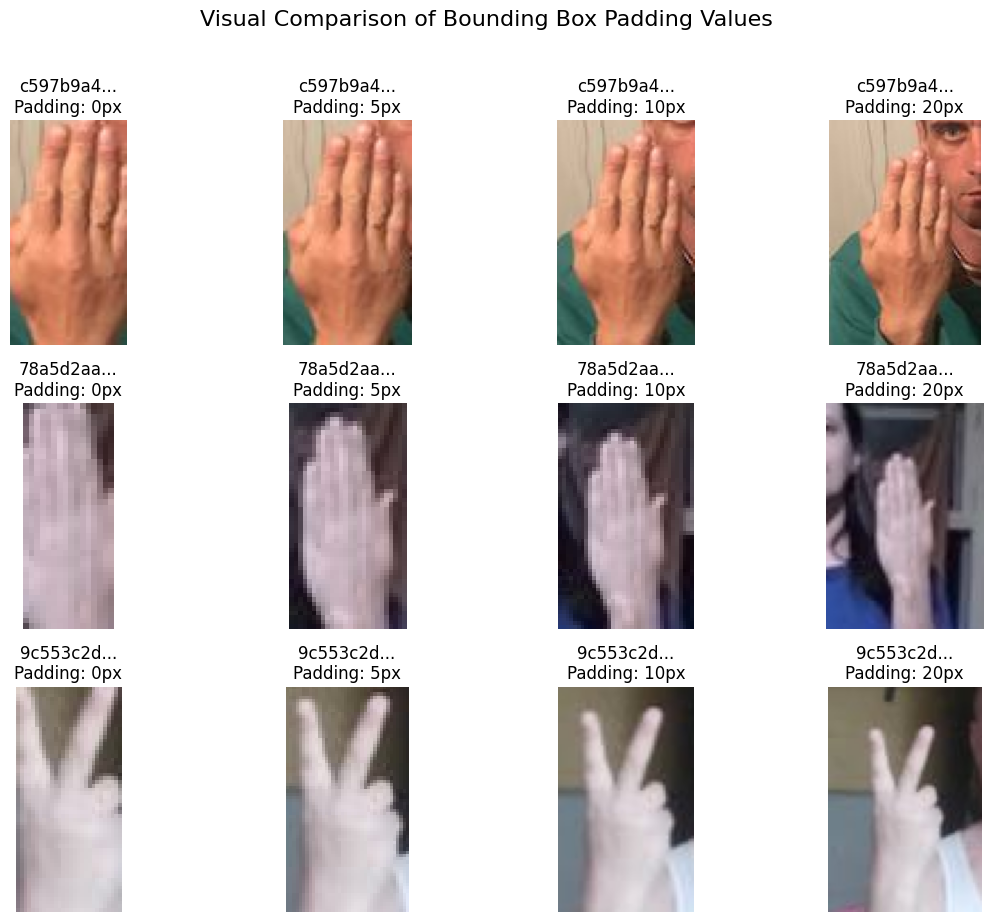


Finished EDA: Padding Comparison.


In [14]:
# ========================================
# Cell: EDA - Justification of Padding Choice (Visual Comparison)
# ========================================
import matplotlib.pyplot as plt
import cv2
import random
from pathlib import Path
import numpy as np
from tqdm import tqdm # Optional, for progress if sampling many

print("Starting EDA: Padding value comparison...")

# --- Prerequisites Check ---
prereqs_ok = True
if 'all_annotations' not in globals() or not all_annotations:
    print("Error: 'all_annotations' dictionary not found or empty. Please run Cell 2 first.")
    prereqs_ok = False
if 'calculate_bounding_box' not in globals():
    print("Error: 'calculate_bounding_box' function not defined. Please run Cell 1 or ensure it's defined.")
    prereqs_ok = False
if 'base_image_dir' not in globals() or not Path(base_image_dir).exists():
    print(f"Error: 'base_image_dir' ({base_image_dir if 'base_image_dir' in globals() else 'Not Set'}) not defined or does not exist.")
    prereqs_ok = False
# --- End Prerequisites Check ---

if prereqs_ok:
    # --- Parameters ---
    padding_values = [0, 5, 10, 20] # Padding values to test
    num_example_images = 3        # How many different images to show
    # --- End Parameters ---

    image_ids_with_landmarks = [
        img_id for img_id, data in all_annotations.items() if data.get("landmarks")
    ]

    if not image_ids_with_landmarks:
        print("No images with landmark annotations found in the loaded data.")
    else:
        num_samples_to_show = min(num_example_images, len(image_ids_with_landmarks))
        if num_samples_to_show < num_example_images:
             print(f"Warning: Only found {num_samples_to_show} images with landmarks.")

        sampled_ids = random.sample(image_ids_with_landmarks, num_samples_to_show)

        num_cols = len(padding_values)
        num_rows = num_samples_to_show
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3)) # Adjust figure size as needed
        if num_rows == 1: axes = np.array([axes]) # Ensure axes is 2D if only one row
        if num_cols == 1: axes = axes.reshape(-1, 1) # Ensure axes is 2D if only one col

        print(f"Generating padding comparison for {num_samples_to_show} images...")

        for row, img_id in enumerate(tqdm(sampled_ids, desc="Processing Sample Images")):
            annotation = all_annotations[img_id]
            landmarks_list = annotation.get("landmarks")

            # Find the original image file path
            possible_paths = list(base_image_dir.rglob(f"{img_id}.jpg"))
            if not possible_paths:
                print(f"Warning: Image file not found for {img_id}. Skipping row.")
                # Optionally fill row with placeholders
                for col in range(num_cols): axes[row, col].set_title(f"{img_id}\nNot Found"); axes[row, col].axis('off')
                continue
            image_path = possible_paths[0]

            img = cv2.imread(str(image_path))
            if img is None:
                print(f"Warning: Could not load image {image_path}. Skipping row.")
                for col in range(num_cols): axes[row, col].set_title(f"{img_id}\nLoad Error"); axes[row, col].axis('off')
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h_img, w_img, _ = img_rgb.shape

            # Use landmarks for the first hand found in the annotation
            if not landmarks_list: continue # Should not happen based on sampling, but safe check
            hand_landmarks = landmarks_list[0] # Using first hand

            # Check format just in case
            if not isinstance(hand_landmarks, list) or not hand_landmarks or not all(isinstance(p, list) and len(p) >= 2 for p in hand_landmarks):
                 print(f"Warning: Invalid landmark format for first hand in {img_id}. Skipping row.")
                 for col in range(num_cols): axes[row, col].set_title(f"{img_id}\nLandmark Error"); axes[row, col].axis('off')
                 continue

            # Generate crop for each padding value
            for col, padding in enumerate(padding_values):
                ax = axes[row, col]
                bbox = calculate_bounding_box(w_img, h_img, hand_landmarks, padding=padding)

                if bbox:
                    x1, y1, x2, y2 = bbox
                    hand_crop = img_rgb[y1:y2, x1:x2]
                    if hand_crop.size > 0:
                        # Display the crop
                        ax.imshow(hand_crop)
                        ax.set_title(f"{img_id[:8]}...\nPadding: {padding}px")
                    else:
                        ax.set_title(f"{img_id[:8]}...\nPadding: {padding}\nEmpty Crop")
                else:
                    ax.set_title(f"{img_id[:8]}...\nPadding: {padding}\nInvalid BBox")

                ax.axis('off')

        plt.suptitle("Visual Comparison of Bounding Box Padding Values", fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()

print("\nFinished EDA: Padding Comparison.")

Starting EDA: PCA Analysis...
Sampling up to 100 images per class for PCA...


Loading Images for PCA: 100%|██████████| 19/19 [00:01<00:00, 10.67it/s]



Extracted features for 1900 images.
Scaling features using StandardScaler...
Features scaled.
Performing PCA...
PCA fitting complete.

Number of principal components needed to capture 90% of variance: 53

Explained variance by the first 20 principal components:
  PC-1: 34.7636% (Cumulative: 34.7636%)
  PC-2: 13.8593% (Cumulative: 48.6229%)
  PC-3: 7.4050% (Cumulative: 56.0279%)
  PC-4: 4.6124% (Cumulative: 60.6403%)
  PC-5: 2.8162% (Cumulative: 63.4564%)
  PC-6: 2.1618% (Cumulative: 65.6182%)
  PC-7: 2.0957% (Cumulative: 67.7139%)
  PC-8: 1.8361% (Cumulative: 69.5500%)
  PC-9: 1.3827% (Cumulative: 70.9327%)
  PC-10: 1.2968% (Cumulative: 72.2294%)
  PC-11: 1.1628% (Cumulative: 73.3923%)
  PC-12: 1.1011% (Cumulative: 74.4934%)
  PC-13: 1.0864% (Cumulative: 75.5798%)
  PC-14: 0.9222% (Cumulative: 76.5020%)
  PC-15: 0.8283% (Cumulative: 77.3303%)
  PC-16: 0.7655% (Cumulative: 78.0958%)
  PC-17: 0.6758% (Cumulative: 78.7716%)
  PC-18: 0.6297% (Cumulative: 79.4013%)
  PC-19: 0.5893% (Cumula

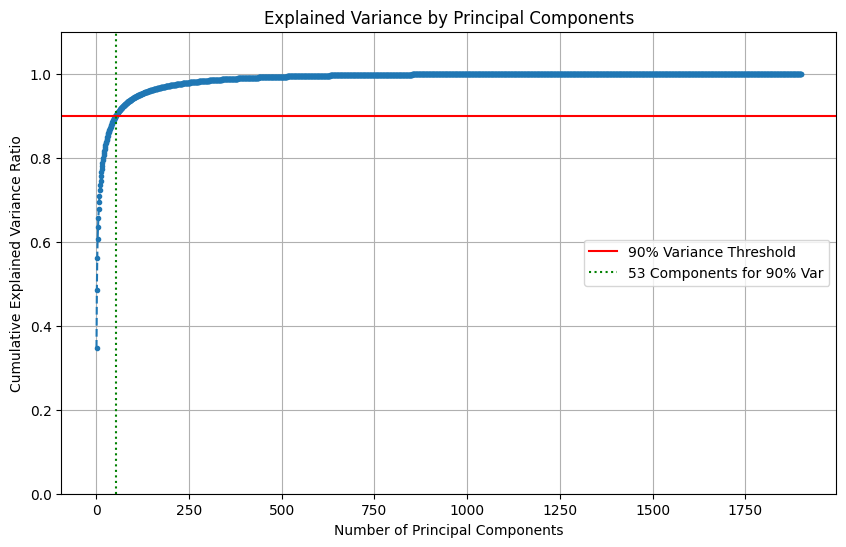

Finished EDA: PCA Analysis.


In [15]:
# ========================================
# Cell: EDA - PCA and Explained Variance Analysis
# ========================================
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm

print("Starting EDA: PCA Analysis...")

# --- Configuration ---
output_dir = Path("hand_crops_json_landmarks_by_label_sampled")
samples_per_class = 100 # Number of samples per class (adjust based on memory/time)
target_img_size = (64, 64) # Resize to this size for feature extraction
n_components_to_print = 20 # How many top components' variance to print
variance_threshold = 0.90 # e.g., 90%
# --- End Configuration ---

# --- Step 1: Load and Prepare Data (Similar to t-SNE setup) ---
features = []
labels = [] # Keep track of labels if needed, though not strictly necessary for PCA itself
all_label_dirs = [d for d in output_dir.iterdir() if d.is_dir()]

if not all_label_dirs:
    print(f"Error: No label subdirectories found in {output_dir}")
else:
    print(f"Sampling up to {samples_per_class} images per class for PCA...")
    for label_dir in tqdm(all_label_dirs, desc="Loading Images for PCA"):
        label = label_dir.name
        image_files = list(label_dir.glob("*.jpg"))
        if not image_files: continue

        sampled_files = random.sample(image_files, min(samples_per_class, len(image_files)))

        for image_path in sampled_files:
             try:
                 img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
                 if img is None: continue
                 img_resized = cv2.resize(img, target_img_size)
                 features.append(img_resized.flatten()) # Flatten pixels
                 labels.append(label)
             except Exception as e:
                 print(f"Error processing {image_path} for PCA: {e}")

    if not features:
        print("No features extracted. Cannot perform PCA.")
    else:
        print(f"\nExtracted features for {len(features)} images.")
        X = np.array(features)

        # --- Step 2: Scale Data ---
        print("Scaling features using StandardScaler...")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        print("Features scaled.")

        # --- Step 3: Perform PCA ---
        print("Performing PCA...")
        # Initialize PCA to potentially compute all components
        pca = PCA()
        # Fit PCA on the scaled data
        pca.fit(X_scaled)
        print("PCA fitting complete.")

        # --- Step 4: Analyze Explained Variance ---
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance_ratio)

        # Find the number of components for the desired variance threshold
        n_components_threshold = np.argmax(cumulative_variance >= variance_threshold) + 1
        print(f"\nNumber of principal components needed to capture {variance_threshold*100:.0f}% of variance: {n_components_threshold}")

        # Print variance for the top N components
        print(f"\nExplained variance by the first {n_components_to_print} principal components:")
        for i in range(min(n_components_to_print, len(explained_variance_ratio))):
            print(f"  PC-{i+1}: {explained_variance_ratio[i]*100:.4f}% (Cumulative: {cumulative_variance[i]*100:.4f}%)")

        # --- Step 5: Plot Cumulative Explained Variance ---
        print("\nGenerating Cumulative Explained Variance Plot...")
        plt.figure(figsize=(10, 6))
        num_components_plot = len(cumulative_variance) # Plot all components
        plt.plot(range(1, num_components_plot + 1), cumulative_variance, marker='.', linestyle='--')
        # Add threshold line
        plt.axhline(y=variance_threshold, color='r', linestyle='-', label=f'{variance_threshold*100:.0f}% Variance Threshold')
        # Add vertical line for threshold components
        plt.axvline(x=n_components_threshold, color='g', linestyle=':', label=f'{n_components_threshold} Components for {variance_threshold*100:.0f}% Var')

        plt.xlabel('Number of Principal Components')
        plt.ylabel('Cumulative Explained Variance Ratio')
        plt.title('Explained Variance by Principal Components')
        plt.grid(True)
        plt.legend(loc='center right')
        plt.ylim(0, 1.1) # Adjust ylim for better visualization
        plt.show()

        print("Finished EDA: PCA Analysis.")

In [16]:
# ========================================
# Cell: Recalculate Counts for ALL Classes
# ========================================
from pathlib import Path
import collections
import os

print("Recalculating crop counts for all available classes...")

# --- Make sure this matches the final output directory name ---
output_dir = Path("hand_crops_json_landmarks_by_label_sampled")
# ---

all_label_counts = collections.defaultdict(int)
found_labels = []

if not output_dir.exists():
     print(f"Error: Output directory '{output_dir}' not found. Cannot determine counts.")
else:
    # Iterate through all items in the output directory
    for item in output_dir.iterdir():
        # Check if it's a directory (representing a label)
        if item.is_dir():
            label = item.name
            # Count the number of .jpg files inside this label directory
            count = len(list(item.glob('*.jpg')))
            if count > 0: # Only include classes where crops were actually saved
                all_label_counts[label] = count
                found_labels.append(label)
            else:
                 print(f"Found directory for '{label}' but it contains no JPG images.")

    if not all_label_counts:
        print(f"No subdirectories containing JPG images found in: {output_dir}")
    else:
        print(f"\nFound {len(all_label_counts)} classes with saved crops:")
        # Sort alphabetically for consistent display
        sorted_found_labels = sorted(all_label_counts.keys())
        for label in sorted_found_labels:
            print(f"- {label}: {all_label_counts[label]}")

        # Store the full counts if needed for other cells (optional)
        # %store all_label_counts

if not all_label_counts:
     print("\nCould not determine counts. Cannot proceed with plotting.")

Recalculating crop counts for all available classes...

Found 19 classes with saved crops:
- call: 8359
- dislike: 8359
- fist: 8359
- four: 8359
- like: 8359
- mute: 8359
- no_gesture: 8359
- ok: 8359
- one: 8359
- palm: 8359
- peace: 8359
- peace_inverted: 8359
- rock: 8359
- stop: 8359
- stop_inverted: 8359
- three: 8359
- three2: 8359
- two_up: 8359
- two_up_inverted: 8359



Starting EDA: Plotting Full Class Distribution...


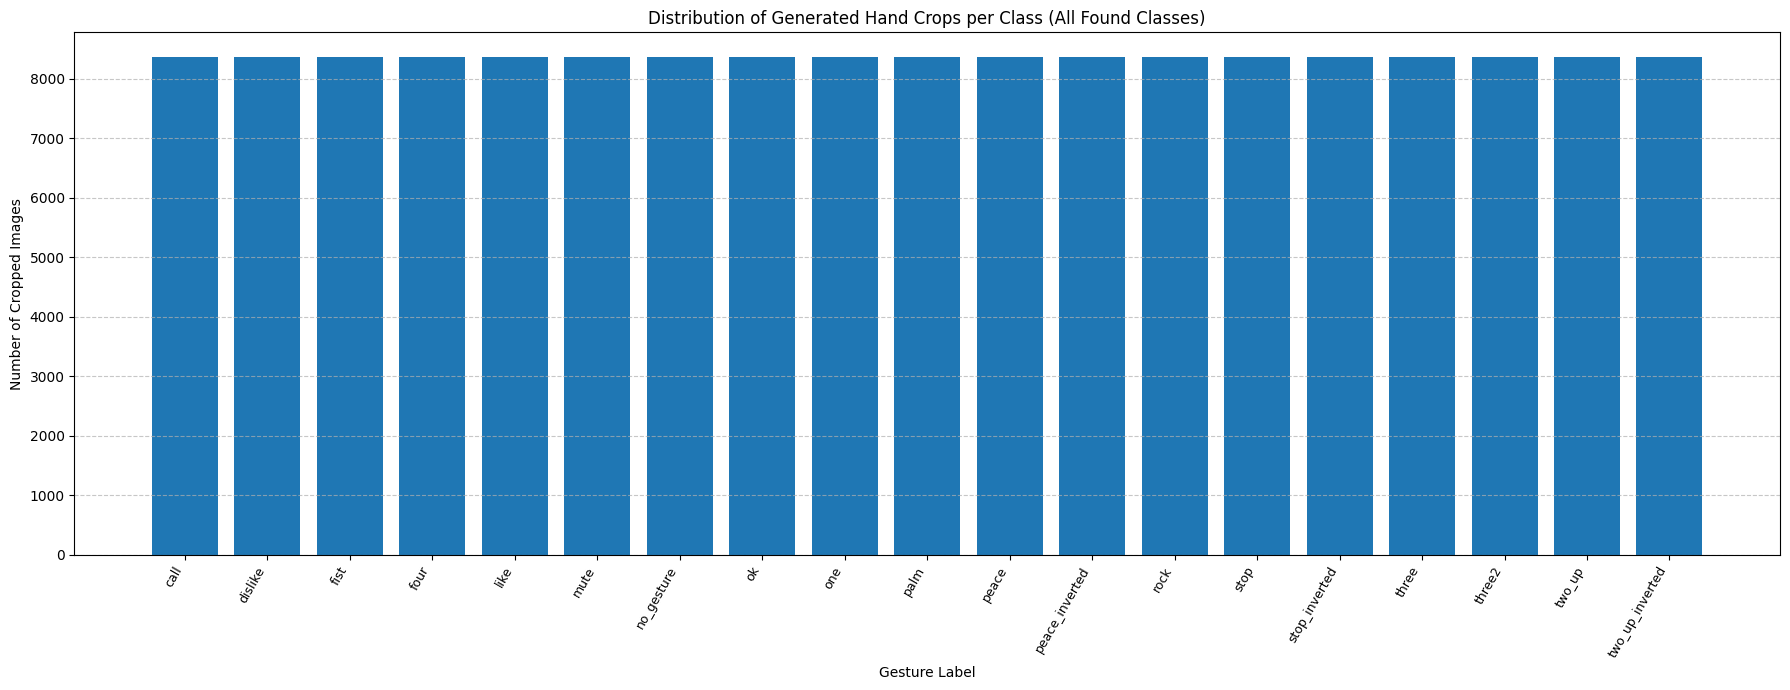

Finished Plotting.


In [17]:
# ========================================
# Cell: Plot Distribution for ALL Found Classes
# ========================================
import matplotlib.pyplot as plt
import matplotlib # Import the main module

# Ensure inline plotting is enabled for Jupyter
%matplotlib inline

print("\nStarting EDA: Plotting Full Class Distribution...")

# Use the 'all_label_counts' calculated in the previous cell
if 'all_label_counts' in locals() and all_label_counts:
    # Sort by label name for consistent plotting order
    sorted_labels = sorted(all_label_counts.keys())
    plot_labels = sorted_labels
    plot_counts = [all_label_counts[lbl] for lbl in sorted_labels]

    plt.figure(figsize=(18, 7)) # Make figure wider for more labels
    bars = plt.bar(plot_labels, plot_counts)
    plt.xlabel("Gesture Label")
    plt.ylabel("Number of Cropped Images")
    plt.title("Distribution of Generated Hand Crops per Class (All Found Classes)")
    plt.xticks(rotation=60, ha='right', fontsize=9) # Rotate labels more for readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Optional: Add counts above bars (can get crowded)
    # for bar in bars:
    #    yval = bar.get_height()
    #    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', fontsize=8, rotation=90)

    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()
    print("Finished Plotting.")

else:
     print("Cannot generate plot - 'all_label_counts' not found or empty. Please run the previous cell.")

Analyzing original image counts per class folder...


Counting images in folders: 100%|██████████| 19/19 [00:05<00:00,  3.20it/s]



Original image counts found per class folder:

Plotting original image distribution...


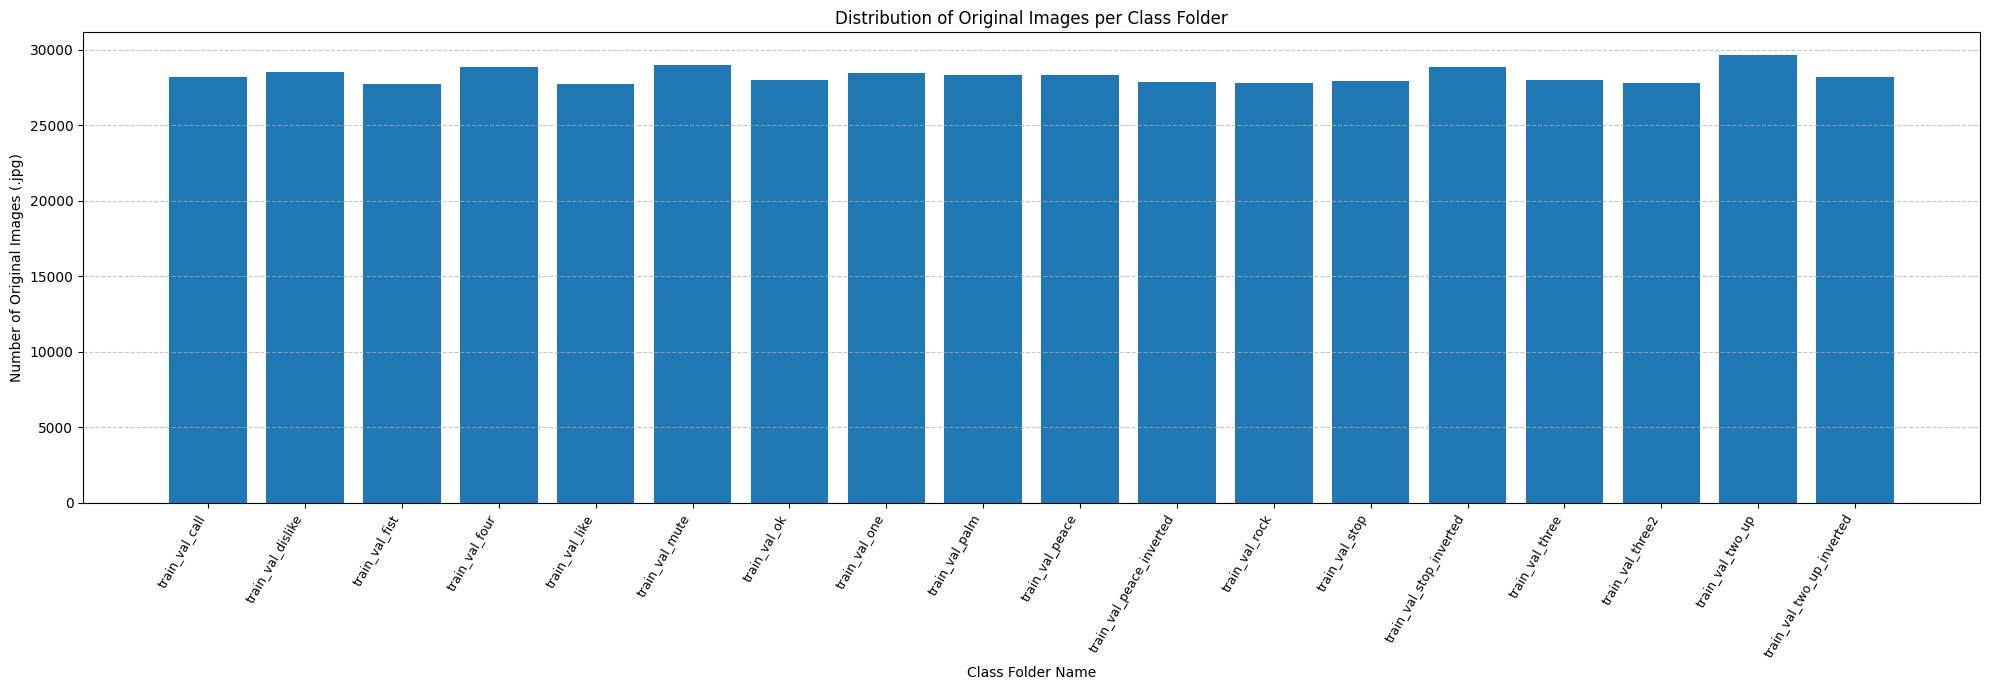


Finished analyzing original image counts.


In [19]:
# ========================================
# Cell: Analyze Original Image Counts per Class Folder
# ========================================
import matplotlib.pyplot as plt
import matplotlib # Ensure main module is imported
from pathlib import Path
import collections
from tqdm import tqdm

# Ensure inline plotting is enabled for Jupyter
%matplotlib inline

print("Analyzing original image counts per class folder...")

# <<< VERIFY THIS PATH is correct for the directory containing the class folders ('train_val_call', etc.) >>>
# Example based on your screenshot image_e8b4ca.png - VERIFY THIS PATH
base_image_dir = Path("/Users/soumyadeepchatterjee/Desktop/WayneState/Winter2025/FinalProject/hagrid-sample-500k-384p/hagrid_500k")

# --- Count image files in each subdirectory ---
original_image_counts = collections.defaultdict(int)
found_class_folders = []

if not base_image_dir.exists():
     print(f"Error: Base image directory '{base_image_dir}' not found. Cannot count files.")
else:
    # Iterate through items directly inside base_image_dir
    for item in tqdm(list(base_image_dir.iterdir()), desc="Counting images in folders"):
        # Check if it's a directory (representing a class folder)
        if item.is_dir():
            class_folder_name = item.name
            # Count the number of .jpg files inside this directory
            # Using glob('*') might be slightly faster if only jpgs are expected
            count = len(list(item.glob('*.jpg'))) # Counts only .jpg files
            if count > 0:
                original_image_counts[class_folder_name] = count
                found_class_folders.append(class_folder_name)
            else:
                 print(f"Found directory '{class_folder_name}' but it contains no JPG images.")

    # --- Plot the Original Image Counts ---
    if not original_image_counts:
        print(f"Did not find any subdirectories with JPG images in: {base_image_dir}")
    else:
        print(f"\nOriginal image counts found per class folder:")
        # Sort alphabetically for consistent plotting order
        sorted_folders = sorted(original_image_counts.keys())
        plot_labels = sorted_folders
        plot_counts = [original_image_counts[lbl] for lbl in plot_labels]

        print("\nPlotting original image distribution...")
        plt.figure(figsize=(20, 7)) # Wider figure
        bars = plt.bar(plot_labels, plot_counts)
        plt.xlabel("Class Folder Name")
        plt.ylabel("Number of Original Images (.jpg)")
        plt.title("Distribution of Original Images per Class Folder")
        plt.xticks(rotation=60, ha='right', fontsize=9) # Rotate labels
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.ylim(bottom=0)
        plt.tight_layout()
        plt.show()

print("\nFinished analyzing original image counts.")

Finding and displaying random original images...
Searching for image files in /Users/soumyadeepchatterjee/Desktop/WayneState/Winter2025/FinalProject/hagrid-sample-500k-384p/hagrid_500k...
Found 509323 original image files.
Displaying 10 random original images...


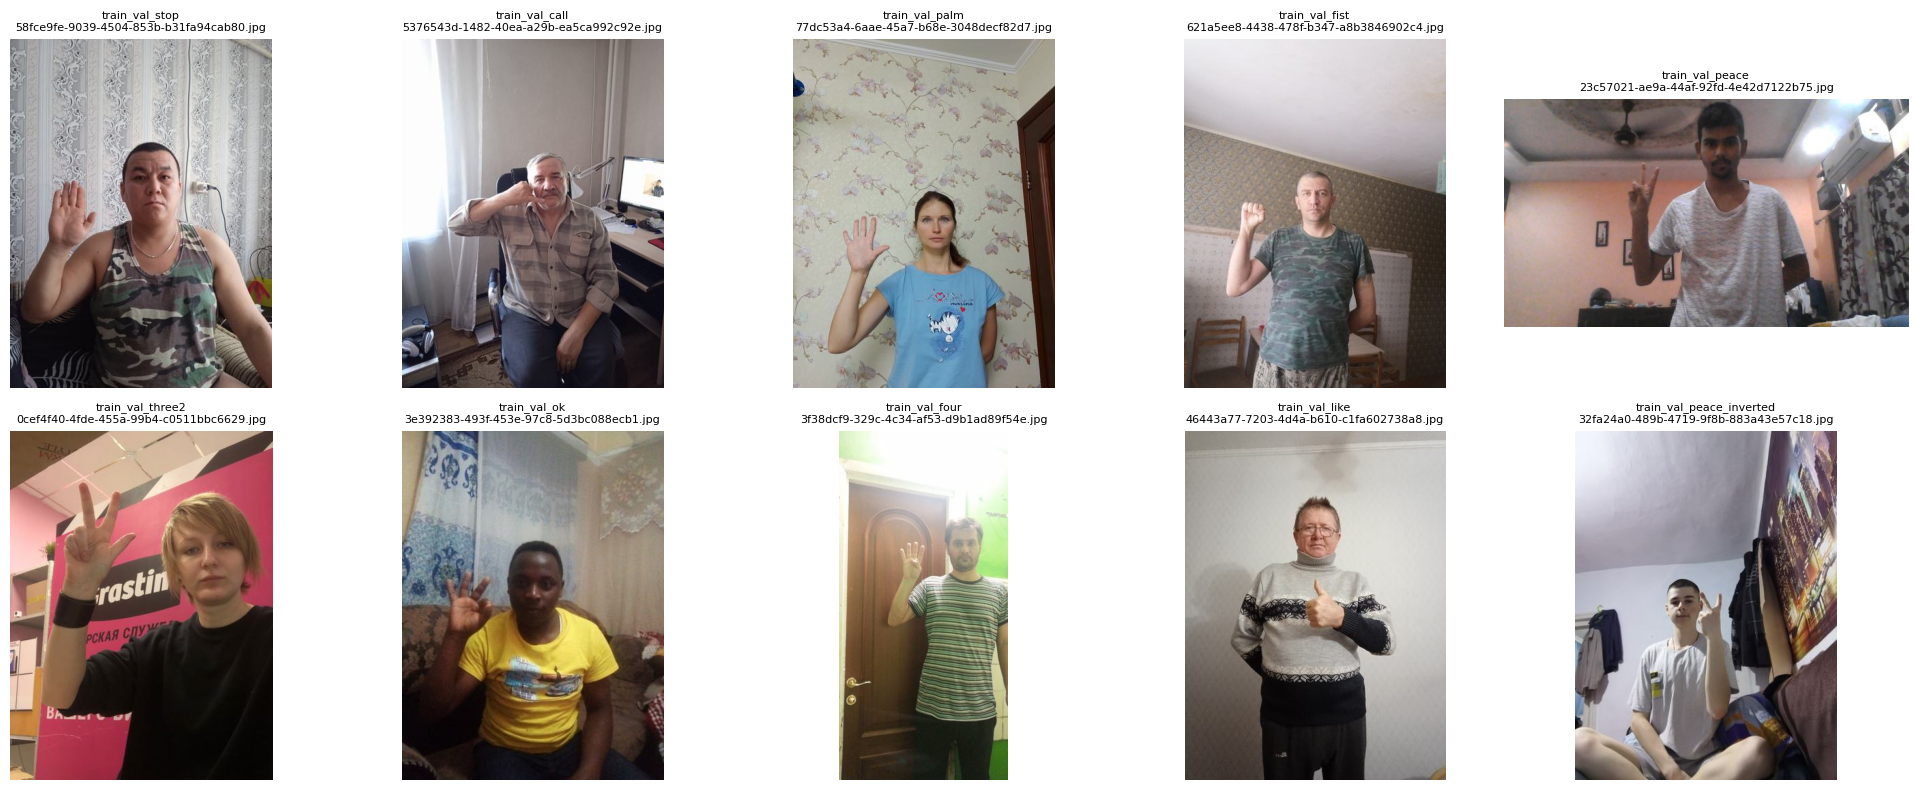


Finished displaying random original images.


In [ ]:
# ========================================
# Cell: Display Random Original Images
# ========================================
import matplotlib.pyplot as plt
import matplotlib # Ensure main module is imported
from pathlib import Path
import random
from PIL import Image # Using PIL for easy display with matplotlib
from tqdm import tqdm # Optional progress bar if listing files is slow

# Ensure inline plotting is enabled for Jupyter
%matplotlib inline

print("Finding and displaying random original images...")

# <<< VERIFY THIS PATH is correct for the folder containing the class subfolders ('train_val_call', etc.) >>>
base_image_dir = Path("/Users/soumyadeepchatterjee/Desktop/WayneState/Winter2025/FinalProject/hagrid-sample-500k-384p/hagrid_500k")

# --- Parameters ---
num_images_to_display = 10
# --- End Parameters ---

if not base_image_dir.exists():
    print(f"Error: Base image directory '{base_image_dir}' not found. Please check the path.")
else:
    print(f"Searching for image files in {base_image_dir}...")
    # Find all .jpg images recursively within the base directory
    all_original_image_files = list(base_image_dir.rglob("*.jpg"))
    print(f"Found {len(all_original_image_files)} original image files.")

    if not all_original_image_files:
        print("No .jpg images found in the specified directory.")
    else:
        # Select random samples
        num_to_sample = min(num_images_to_display, len(all_original_image_files))
        if num_to_sample < num_images_to_display:
            print(f"Warning: Found only {num_to_sample} images, displaying all of them.")

        selected_files = random.sample(all_original_image_files, num_to_sample)

        # Determine grid size
        num_cols = 5
        num_rows = (num_to_sample + num_cols - 1) // num_cols # Calculate rows needed

        # Create plot
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4)) # Adjust size as needed
        # Flatten axes array for easy iteration, handle cases with < num_cols images
        axes = axes.flatten()

        print(f"Displaying {num_to_sample} random original images...")
        for i, image_path in enumerate(selected_files):
            ax = axes[i]
            try:
                img = Image.open(image_path)
                ax.imshow(img)
                # Show parent folder (label) and filename
                ax.set_title(f"{image_path.parent.name}\n{image_path.name}", fontsize=8)
            except Exception as e:
                print(f"Error loading or displaying {image_path}: {e}")
                ax.set_title(f"Error loading\n{image_path.name}", fontsize=8)
            ax.axis('off')

        # Turn off axes for any remaining empty subplots
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()

print("\nFinished displaying random original images.")

Finding and displaying random original images with labels...
Searching for image files in /Users/soumyadeepchatterjee/Desktop/WayneState/Winter2025/FinalProject/hagrid-sample-500k-384p/hagrid_500k...
Found 509323 original image files.
Displaying 10 random original images...


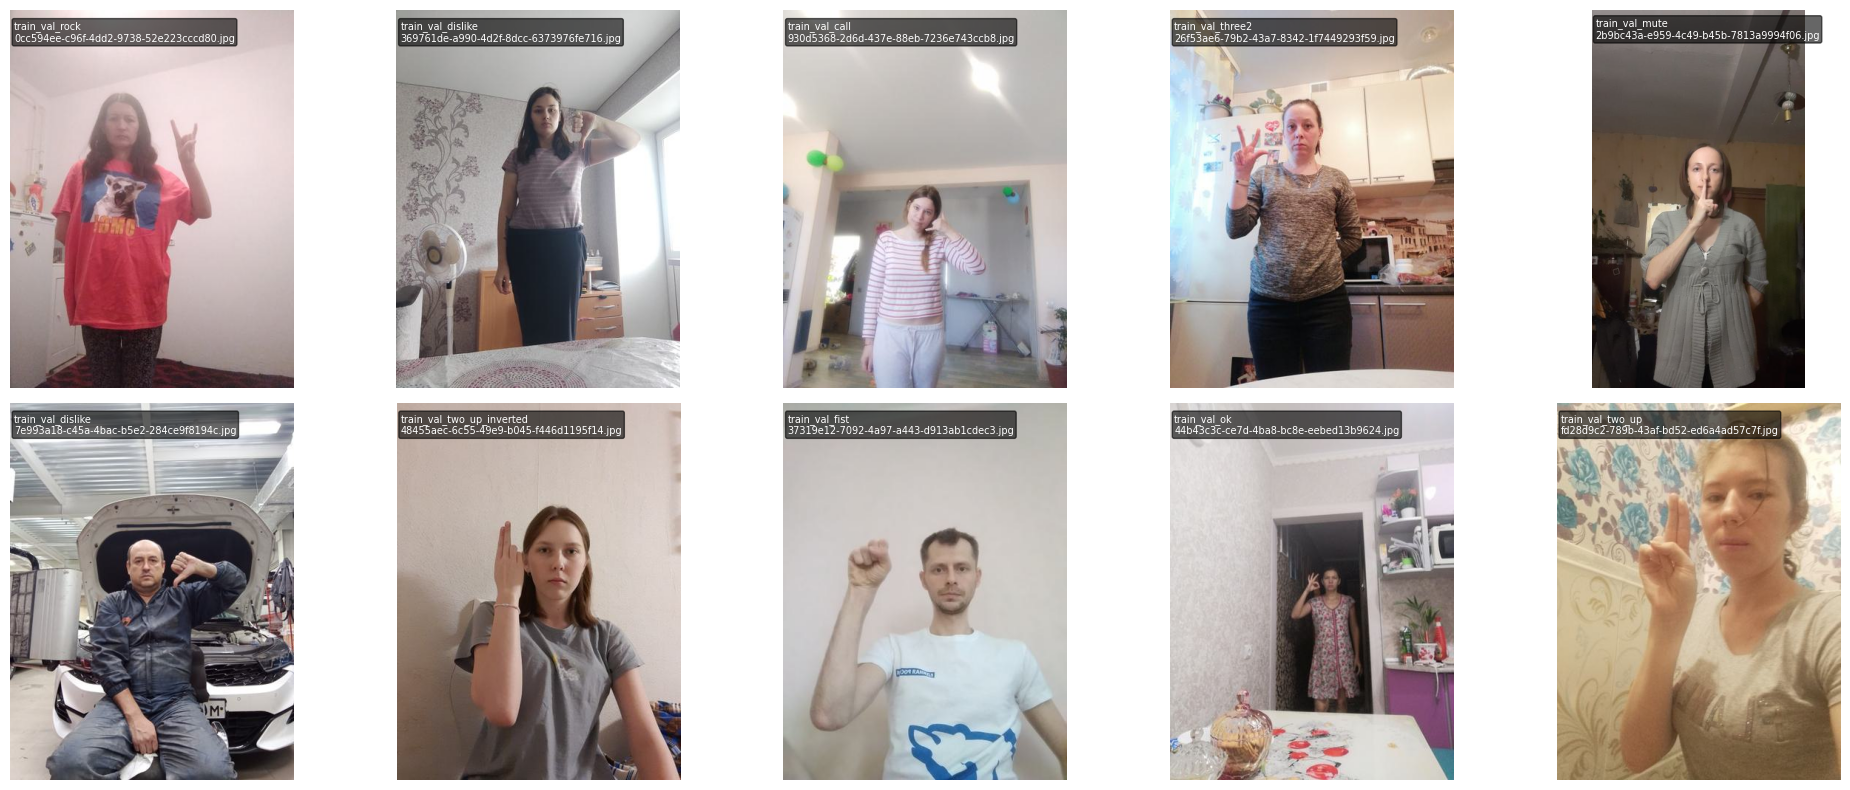


Finished displaying random original images.


In [21]:
# ========================================
# Cell: Display Random Original Images (with Labels on Top)
# ========================================
import matplotlib.pyplot as plt
import matplotlib # Ensure main module is imported
from pathlib import Path
import random
from PIL import Image # Using PIL for easy display with matplotlib
from tqdm import tqdm # Optional progress bar

# Ensure inline plotting is enabled for Jupyter
%matplotlib inline

print("Finding and displaying random original images with labels...")

# <<< VERIFY THIS PATH is correct for the folder containing the class subfolders ('train_val_call', etc.) >>>
base_image_dir = Path("/Users/soumyadeepchatterjee/Desktop/WayneState/Winter2025/FinalProject/hagrid-sample-500k-384p/hagrid_500k")

# --- Parameters ---
num_images_to_display = 10
# --- End Parameters ---

if not base_image_dir.exists():
    print(f"Error: Base image directory '{base_image_dir}' not found. Please check the path.")
else:
    print(f"Searching for image files in {base_image_dir}...")
    all_original_image_files = list(base_image_dir.rglob("*.jpg"))
    print(f"Found {len(all_original_image_files)} original image files.")

    if not all_original_image_files:
        print("No .jpg images found in the specified directory.")
    else:
        # Select random samples
        num_to_sample = min(num_images_to_display, len(all_original_image_files))
        if num_to_sample < num_images_to_display:
            print(f"Warning: Found only {num_to_sample} images, displaying all of them.")

        selected_files = random.sample(all_original_image_files, num_to_sample)

        # Determine grid size
        num_cols = 5
        num_rows = (num_to_sample + num_cols - 1) // num_cols

        # Create plot
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
        axes = axes.flatten() # Flatten axes array

        print(f"Displaying {num_to_sample} random original images...")
        for i, image_path in enumerate(selected_files):
            ax = axes[i]
            label_text = f"{image_path.parent.name}\n{image_path.name}" # Get text first
            try:
                img = Image.open(image_path)
                ax.imshow(img)
                # ax.set_title(label_text, fontsize=8) # Keep title or remove if text is enough

                # --- MODIFICATION START: Add text overlay ---
                # Position text near top-left corner (adjust x, y as needed)
                text_x = 5
                text_y = 15 # Pixel offset from top
                ax.text(text_x, text_y, label_text,
                        color='white', # Text color
                        fontsize=7,   # Adjust font size
                        ha='left',    # Horizontal alignment
                        va='top',     # Vertical alignment
                        # Add a background box for better readability
                        bbox=dict(boxstyle='round,pad=0.2', fc='black', alpha=0.6))
                # --- MODIFICATION END ---

            except Exception as e:
                print(f"Error loading or displaying {image_path}: {e}")
                ax.set_title(f"Error loading\n{image_path.name}", fontsize=8)
            ax.axis('off')

        # Turn off axes for any remaining empty subplots
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()

print("\nFinished displaying random original images.")

Finding and displaying random original images with labels...
Searching for image files in /Users/soumyadeepchatterjee/Desktop/WayneState/Winter2025/FinalProject/hagrid-sample-500k-384p/hagrid_500k...
Found 509323 original image files.
Displaying 10 random original images...


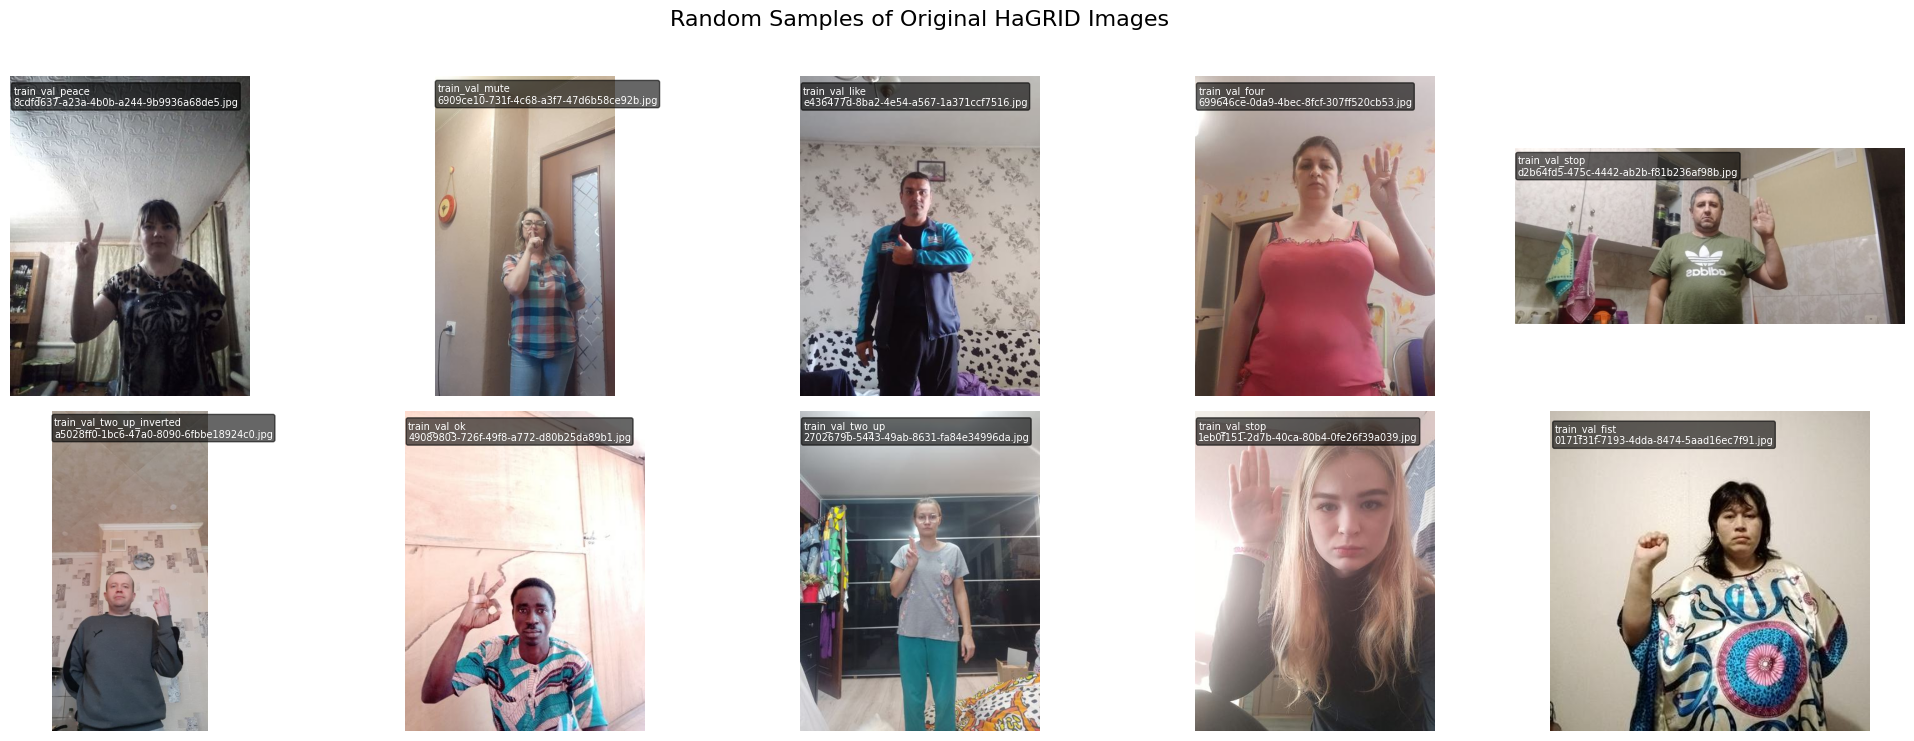


Finished displaying random original images.


In [22]:
# ========================================
# Cell: Display Random Original Images (with Labels on Top AND Heading)
# ========================================
import matplotlib.pyplot as plt
import matplotlib # Ensure main module is imported
from pathlib import Path
import random
from PIL import Image # Using PIL for easy display with matplotlib
from tqdm import tqdm # Optional progress bar

# Ensure inline plotting is enabled for Jupyter
%matplotlib inline

print("Finding and displaying random original images with labels...")

# <<< VERIFY THIS PATH is correct for the folder containing the class subfolders ('train_val_call', etc.) >>>
base_image_dir = Path("/Users/soumyadeepchatterjee/Desktop/WayneState/Winter2025/FinalProject/hagrid-sample-500k-384p/hagrid_500k")

# --- Parameters ---
num_images_to_display = 10
# --- End Parameters ---

if not base_image_dir.exists():
    print(f"Error: Base image directory '{base_image_dir}' not found. Please check the path.")
else:
    print(f"Searching for image files in {base_image_dir}...")
    all_original_image_files = list(base_image_dir.rglob("*.jpg"))
    print(f"Found {len(all_original_image_files)} original image files.")

    if not all_original_image_files:
        print("No .jpg images found in the specified directory.")
    else:
        # Select random samples
        num_to_sample = min(num_images_to_display, len(all_original_image_files))
        if num_to_sample < num_images_to_display:
            print(f"Warning: Found only {num_to_sample} images, displaying all of them.")

        selected_files = random.sample(all_original_image_files, num_to_sample)

        # Determine grid size
        num_cols = 5
        num_rows = (num_to_sample + num_cols - 1) // num_cols

        # Create plot
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
        axes = axes.flatten() # Flatten axes array

        print(f"Displaying {num_to_sample} random original images...")
        for i, image_path in enumerate(selected_files):
            ax = axes[i]
            label_text = f"{image_path.parent.name}\n{image_path.name}" # Get text first
            try:
                img = Image.open(image_path)
                ax.imshow(img)
                # ax.set_title(label_text, fontsize=8) # Optional individual titles

                # Add text overlay
                text_x = 5
                text_y = 15 # Pixel offset from top
                ax.text(text_x, text_y, label_text,
                        color='white', fontsize=7,
                        ha='left', va='top',
                        bbox=dict(boxstyle='round,pad=0.2', fc='black', alpha=0.6))

            except Exception as e:
                print(f"Error loading or displaying {image_path}: {e}")
                ax.set_title(f"Error loading\n{image_path.name}", fontsize=8)
            ax.axis('off')

        # Turn off axes for any remaining empty subplots
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        # --- MODIFICATION START: Add Overall Heading ---
        plt.suptitle("Random Samples of Original HaGRID Images", fontsize=16, y=0.95) # Adjust y for spacing below title bar
        # --- MODIFICATION END ---

        plt.tight_layout(rect=[0, 0.03, 1, 0.93]) # Adjust rect to make space for suptitle if needed
        plt.show()

print("\nFinished displaying random original images.")